# Purpose

1) Identify the baseline data for China

* China COVID-19 data from NHC reports:

* Formatted Hospital Beds and Agegroups data from UN database: http://data.un.org/Data.aspx?d=POP&f=tableCode:22, http://data.un.org/Data.aspx?q=beds&d=WHO&f=MEASURE_CODE:WHS6_102

2) Create a baseline SIRD model for China

3) Create a SELIRCD model for China

4) Evaluate SELIRCD by comparing results to raw data and to SIRD


# Data

We will be working with cumulative China data from China NHC (National Health Commission).

In [2]:
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from helpers.plot import plotter
import matplotlib.dates as mdates

In [3]:
#China case data
china = pd.read_csv("Data/chinadata_nhc.csv", header = 0)
china

,country,date,confirmed_new,confirmed_ttl,suspected_new,suspected_ttl,severe_new,severe_ttl,medical_observation,deaths_new,deaths_ttl,recovery_new,recovery_ttl,imported_new,imported_ttl,asymptomatic_new,asymptomatic_ttl
0,China,1/21/20,77,291,27,54,NaN,NaN,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,China,1/22/20,149,440,26,37,NaN,NaN,1394,3.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2,China,1/23/20,131,571,257,393,NaN,95.0,4928,8.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,China,1/24/20,259,830,680,1072,82.0,177.0,8420,8.0,25.0,6.0,NaN,NaN,NaN,NaN,NaN
4,China,1/25/20,444,1287,1118,1965,60.0,237.0,1230,16.0,41.0,3.0,38.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,China,5/10/20,14,82901,1,4,-2.0,13.0,5840,0.0,4633.0,74.0,78120.0,2.0,1683.0,20.0,794.0
111,China,5/11/20,17,82918,0,3,-4.0,9.0,5501,0.0,4633.0,24.0,78144.0,7.0,1690.0,12.0,780.0
112,China,5/12/20,1,82919,1,3,-1.0,10.0,5470,0.0,4633.0,80.0,78171.0,1.0,1691.0,15.0,760.0
113,China,5/13/20,7,82926,1,4,0.0,10.0,5317,0.0,4633.0,18.0,78189.0,1.0,1692.0,8.0,750.0


This is what the COVID-19 scene looks like in China.

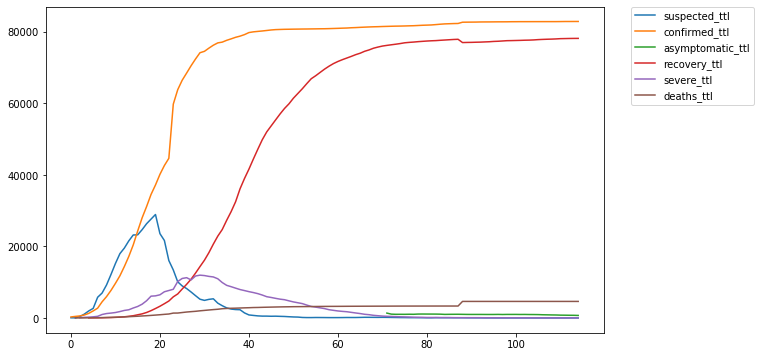

In [4]:
#Plot China raw data
china[["suspected_ttl","confirmed_ttl","asymptomatic_ttl","recovery_ttl","severe_ttl","deaths_ttl"]].plot(figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

**AGE GROUPS:** We get age group demographics from the UN database. Grouping data and aggregating over age groups, we somehow get that the population total > actual population in 2010 (most recent data for China in this dataset). Not sure why this is. 

Assuming the age *structure* has not changed (source:https://www.statista.com/statistics/270163/age-distribution-in-china/), we rescale this to 2020 numbers.

In [5]:
#Age group demographics for some countries, for both sexes, most recent year of data (orig data 1955-2019)
agegroups = pd.read_csv("Data/agegroups_UNdata_mostrecentrecs.csv", header=0)

#China age group data
agegroups = agegroups.to_numpy()[3][3:] #this sums to more than 1.4bil...
curr_pop = 1439323776 #googled this estimate of total china population 2020

agegroups = (agegroups/np.sum(agegroups)) * curr_pop #estimates of 2020 age group counts
N = sum(agegroups) #ttl pop

**BEDS:** We also have info on beds per 10K. This info is relatively old on most countries, but most countries have not changed much over the years (see R cleaning/exploratory file for a visualization). 

In [6]:
#Beds data for most countries, most recent year documented, beds per 10,000 people
beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
idx = beds.groupby(['country_area'])['years'].transform(max) == beds['years']
beds = beds[idx]
beds = beds[['country_area','years','beds']]
beds = beds.rename(columns={"country_area": "Country", "years":"Year", "beds": "ICU_Beds"})

# create dict for fast lookup
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
beds_per_10k = beds_lookup["China"]
beds

#note: are smaller countries more likely to have discrepancies than larger countries?

,Country,Year,ICU_Beds
0,Afghanistan,2010,4
2,Albania,2009,28
4,Algeria,2004,17
5,Andorra,2009,25
7,Angola,2005,8
...,...,...,...
315,Venezuela (Bolivarian Republic of),2009,11
317,Viet Nam,2009,31
319,Yemen,2010,7
321,Zambia,2010,20


# Baseline: SIRD Model (Susceptible-Infected-Recovered-Dead)

Susceptible people can become infected, who can in turn recover or die.

At each stage, 
$\alpha \dfrac{I}{N} S$ people move from $S \rightarrow I$, 

$\beta  (1 - p_{I\rightarrow D})  I$ people move from $I \rightarrow R$, 
and

$\gamma p_{I\rightarrow D}  I$ people move from $I \rightarrow D$. 



Here are the differential equations used:

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \alpha  \dfrac{I}{N} S \\
\dfrac{\delta I}{\delta t} &= \alpha  \dfrac{I}{N} S - \beta  (1 - p_{I\rightarrow D})  I - \gamma p_{I\rightarrow D}  I\\
\dfrac{\delta R}{\delta t} &= \beta  (1 - p_{I\rightarrow D})  I\\
\dfrac{\delta D}{\delta t} &= \gamma p_{I\rightarrow D}  I
\end{align*}$$

where
$$\begin{align*}
\alpha &= infection\ rate\\
\beta &= recovery\ rate\\
\gamma &= death\ rate\\
\\
\frac{I}{N} &= probability\ of\ infection\\
(1 - p_{I\rightarrow D}) &= probability\ of\ recovery\\
p_{I\rightarrow D} &= probability\ of\ death
\end{align*}$$


Recovery and death rates once infected can be assumed to be constant. The time to recovery is roughly 2 weeks, and the time til death is approx. 2-8 weeks (according to China WHO report: https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf#:~:text=Using%20available%20preliminary%20data%2C,severe%20or%20critical%20disease). 

Infection rate may change over time depending on $R_0$, and the probabilities of recovering or dying can be fitted. We assume a logistic curve for $R_0$ over time, which require $R_{0\ start}$, $R_{0\ end}$, start day $x_0$, and steepness parameter $k$ to fit. 

So $\alpha(t)$ is a changing parameter, and params that need fitting include $R_{0\ start}$, $R_{0\ end}$, $x_0$, $k$, and $p_{I\rightarrow D}$.



In [58]:
#Fixed params
beta = 1/14
gamma = 1/18.5 #guess around 5 weeks for infection --> death

#Params to fit ( form: {parameter: (initial guess, minimum value, max value)} )
params_init_min_max = {"R_0_start": (3.0, 1.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (80, 0, 120), "R_0_end": (0.9, 0.3, 3.5), "p_I_to_D": (0.02, 0.0, 1.0)}

In [59]:
def deriv(y, t, N, alpha, beta, gamma, p_I_to_D):
    S, I, R, D = y

    dSdt = - alpha(t) * (I / N) * S
    dIdt = alpha(t) * (I / N) * S - beta * (1-p_I_to_D) * I - gamma * p_I_to_D * I
    dRdt = beta * (1-p_I_to_D) * I
    dDdt = gamma * p_I_to_D * I
    
    return dSdt, dIdt, dRdt, dDdt

In [60]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [61]:
def Model(days, agegroups, beta, gamma, p_I_to_D, R_0_start, k, x0, R_0_end):
    # infection rate comes from current R0
    def alpha(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * beta
    
    N = sum(agegroups)
    y0 = N-1.0, 1.0, 0.0, 0.0
    t = np.linspace(0, days, days) # Grid of time points (in days)
    
    #fit the model
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma, p_I_to_D))
    S, I, R, D = ret.T
    R_0_over_time = [alpha(i)/beta for i in range(len(t))]
    return t, S, I, R, D, R_0_over_time, p_I_to_D

In [71]:
#Set reference data (x_data is days, y_data is number of cumulative deaths)
outbreak_shift = -1
data = china["deaths_ttl"].to_numpy()
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [72]:
#Fit the model to get predicted cumulative deaths
def fitter(x, R_0_start, k, x0, R_0_end, p_I_to_D):
    ret = Model(days, agegroups, beta, gamma, p_I_to_D, R_0_start, k, x0, R_0_end)
    return ret[4][x] #pred cumulative deaths, all entries

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

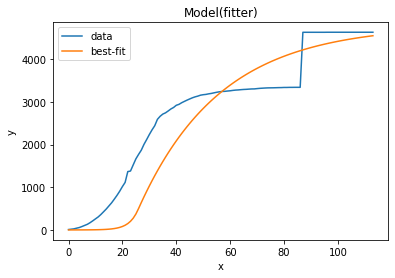

{'R_0_start': 4.999999999999999, 'k': 4.999999999999999, 'x0': 25.963091189864492, 'R_0_end': 0.30000000000000004, 'p_I_to_D': 0.9999999999999977}


In [73]:
params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)
ax= plt.subplots()
result.plot_fit(datafmt="-", ax=ax);
plt.show()
print(result.best_values)

Plot above is of fitted vs actual number of deaths (num deaths more reliable than the other categories, which can vary a lot due to testing availability and reporting biases).

**MODEL EVALUATION:** 

In [56]:
#MSE
np.mean(result.residual **2) 

386251.07321232435

In [57]:
result #how well pred vs reported deaths compare, using fitted params

# SELIRCD Model

In [54]:
#Note: What model works best at which time periods?
#Note: Do models work better for smaller vs larger countries?
#Note: Data in the Netherlands -- summaries/recommendations we want to see improvement on (request from ministry of health there)
#Try Switzerland, South Korea, Taiwan
#Note: a couple months (1-2) ahead prediction is minimum
#Fixed params (tweak these?)
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death
 
#Params to fit
#Note: For which countries are we hitting the boundaries of the parameters?
params_init_min_max = {"R_0_start": (3.0, 2.0, 100.0), "k": (2.5, 0.01, 150.0), "x0": (20, 0, 100), "R_0_end": (0.9, 0.00, 3.5), "p_L_to_R": (0.6, 0.0, 1.0),
                       "p_I_to_C": (0.05, 0.001, 1.0), "p_C_to_D": (0.5, 0.005, 1.0),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [55]:
#Diff eqs
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    # def alpha(t):
    #     return s * I/N + alpha_opt
    dSdt = - beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

In [56]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [57]:
#Model
def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    # infection rate comes from current R0
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    # model bed usage in the poplation
    def beds(t):
        beds_0 = beds_per_10k / 10_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    # run model
    N = sum(agegroups)
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D, delta

In [58]:
#Set reference data (x_data is days, y_data is number of cumulative deaths)
outbreak_shift = -2
data = china["severe_ttl"].to_numpy()[:80]
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift+2), data[2:]))
else:
    y_data = data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [59]:
#Fit the model to get predicted cumulative deaths
def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
    return ret[5][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


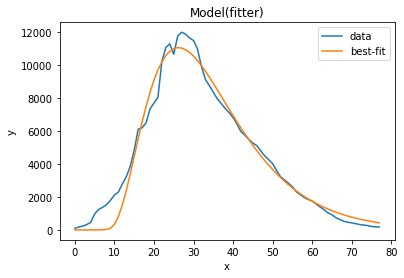

{'R_0_start': 99.99999999999999, 'k': 149.9982742909608, 'x0': 8.86901901577715, 'R_0_end': 4.216341644086603e-23, 'p_L_to_R': 0.7142457893383738, 'p_I_to_C': 0.9999999999999999, 'p_C_to_D': 0.7280018203916949, 's': 0.003}


In [60]:
params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)
ax= plt.subplots()
result.plot_fit(datafmt="-", ax=ax);
plt.show()
print(result.best_values)

#Note: Try backfitting (censor later part of data and eval)

**MODEL EVALUATION:** 

In [45]:
#MSE
np.mean(result.residual **2)

43741.143544468876

In [46]:
result #this has more params to fit, so more dof thus naturally higher AIC